In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
import warnings
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')
from tqdm import tqdm
import lightgbm as lgb
import gc
import datetime
import time
warnings.filterwarnings('ignore')

In [2]:
train = pickle.load(open('train_features.pkl','rb'))

In [3]:
train.head()

,product_id,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered,cos_cyclic_hour,sin_cyclic_hour,...,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29
0,33120,202279,1050357,9,1,14,30,1,-0.866211,-0.5,...,0.05855,-0.241675,-0.104688,-0.025783,0.2425,0.331574,-0.260521,-0.076831,0.017537,-0.183978
1,33120,122042,1770556,11,1,14,30,0,-0.866211,-0.5,...,0.05855,-0.241675,-0.104688,-0.025783,0.2425,0.331574,-0.260521,-0.076831,0.017537,-0.183978
2,33120,197605,2093514,26,1,14,30,1,-0.866211,-0.5,...,0.05855,-0.241675,-0.104688,-0.025783,0.2425,0.331574,-0.260521,-0.076831,0.017537,-0.183978
3,33120,48533,1350816,11,1,14,30,0,-0.866211,-0.5,...,0.05855,-0.241675,-0.104688,-0.025783,0.2425,0.331574,-0.260521,-0.076831,0.017537,-0.183978
4,33120,7443,2049554,8,1,14,30,0,-0.866211,-0.5,...,0.05855,-0.241675,-0.104688,-0.025783,0.2425,0.331574,-0.260521,-0.076831,0.017537,-0.183978


In [4]:
X = train.drop(['product_id','order_id'],axis=1)

In [5]:
train.user_id.nunique()

131209

In [6]:
total_users = list(train.user_id.unique())
total_users[:5]

[202279, 122042, 197605, 48533, 7443]

In [7]:
random.shuffle(total_users)

In [8]:
total_users[:5]

[8999, 33512, 193417, 11726, 63218]

In [9]:
train_users = total_users[:101209]
test_users  = total_users[101209:]

In [10]:
len(train_users),len(test_users),len(total_users)

(101209, 30000, 131209)

In [11]:
X.set_index('user_id').loc[train_users,:]['reordered'].value_counts()

0    6003832
1     647555
Name: reordered, dtype: int64

In [ ]:
X_train = X.set_index('user_id').loc[train_users,:]
X_test  = X.set_index('user_id').loc[test_users,:]

In [ ]:
y_train = X_train.reordered
y_test  = X_test.reordered
X_train = X_train.drop(['reordered'],axis=1)
X_test = X_test.drop(['reordered'],axis=1)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6632972, 54), (1972898, 54), (6632972,), (1972898,))

In [ ]:
gc.collect()

0

In [ ]:
lgbm=LGBMClassifier(device_type='gpu')

prams={
    'learning_rate':[0.05,0.1,0.15,0.2],
     'n_estimators':[50,100,150,200,300],
     'max_depth':[3,5,8,10],
     'num_leaves':[31,62,93],
     'class_weight':[{0:1,1:5},{0:1,1:10},{0:1,1:50}],
}
lgbm_cfl1=RandomizedSearchCV(lgbm,param_distributions=prams,verbose=10,scoring='f1',return_train_score=True,cv=3)
lgbm_cfl1.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START class_weight={0: 1, 1: 50}, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=93
[CV 1/3; 1/10] END class_weight={0: 1, 1: 50}, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=93; total time=  48.3s
[CV 2/3; 1/10] START class_weight={0: 1, 1: 50}, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=93
[CV 2/3; 1/10] END class_weight={0: 1, 1: 50}, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=93; total time=  48.2s
[CV 3/3; 1/10] START class_weight={0: 1, 1: 50}, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=93
[CV 3/3; 1/10] END class_weight={0: 1, 1: 50}, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=93; total time=  47.9s
[CV 1/3; 2/10] START class_weight={0: 1, 1: 50}, learning_rate=0.05, max_depth=5, n_estimators=70, num_leaves=93
[CV 1/3; 2/10] END class_weight={0: 1, 1: 50}, learning_rate=0.05, max_depth=5, n_estimators=7

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(device_type='gpu'),
                   param_distributions={'class_weight': [{0: 1, 1: 5},
                                                         {0: 1, 1: 10},
                                                         {0: 1, 1: 50}],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [5, 8, 10],
                                        'n_estimators': [70, 100, 150, 200,
                                                         300],
                                        'num_leaves': [31, 62, 93]},
                   return_train_score=True, scoring='f1', verbose=10)

In [ ]:
pd.DataFrame(lgbm_cfl1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,38.308250,0.074506,9.801586,0.095338,93,200,5,0.1,"{0: 1, 1: 50}","{'num_leaves': 93, 'n_estimators': 200, 'max_d...",0.223525,0.224152,0.224841,0.224173,0.000537,9,0.224628,0.225040,0.224717,0.224795,0.000177
1,21.506200,0.059773,4.343197,0.008269,93,70,5,0.05,"{0: 1, 1: 50}","{'num_leaves': 93, 'n_estimators': 70, 'max_de...",0.215132,0.215883,0.216158,0.215724,0.000434,10,0.215768,0.216202,0.215509,0.215826,0.000286
2,50.557674,0.072111,13.802671,0.212984,62,300,10,0.1,"{0: 1, 1: 10}","{'num_leaves': 62, 'n_estimators': 300, 'max_d...",0.363141,0.362326,0.363483,0.362983,0.000486,1,0.368311,0.368580,0.368030,0.368307,0.000224
3,47.171308,0.244709,12.427966,0.119026,31,300,8,0.1,"{0: 1, 1: 50}","{'num_leaves': 31, 'n_estimators': 300, 'max_d...",0.225338,0.225924,0.226374,0.225879,0.000424,7,0.226995,0.227434,0.226769,0.227066,0.000276
4,20.567227,0.064628,4.488995,0.023273,31,70,5,0.2,"{0: 1, 1: 10}","{'num_leaves': 31, 'n_estimators': 70, 'max_de...",0.359050,0.357985,0.359273,0.358769,0.000562,4,0.360042,0.360106,0.360099,0.360082,0.000029
5,29.990971,0.053543,7.448748,0.169874,31,150,8,0.15,"{0: 1, 1: 50}","{'num_leaves': 31, 'n_estimators': 150, 'max_d...",0.224490,0.225273,0.225979,0.225247,0.000608,8,0.225768,0.226438,0.226106,0.226104,0.000274
6,26.610722,0.147394,6.177734,0.044868,93,100,10,0.2,"{0: 1, 1: 10}","{'num_leaves': 93, 'n_estimators': 100, 'max_d...",0.362628,0.361261,0.362901,0.362263,0.000718,2,0.368080,0.367596,0.367454,0.367710,0.000268
7,51.290805,0.169293,15.381318,0.017197,93,300,8,0.2,"{0: 1, 1: 50}","{'num_leaves': 93, 'n_estimators': 300, 'max_d...",0.235315,0.235924,0.236487,0.235909,0.000479,6,0.242825,0.243783,0.242677,0.243095,0.000490
8,25.335725,0.097043,5.647493,0.053756,31,100,5,0.1,"{0: 1, 1: 10}","{'num_leaves': 31, 'n_estimators': 100, 'max_d...",0.358092,0.356480,0.358946,0.357839,0.001022,5,0.358885,0.358324,0.359143,0.358784,0.000342
9,24.649941,0.171679,5.679319,0.071438,31,100,5,0.2,"{0: 1, 1: 10}","{'num_leaves': 31, 'n_estimators': 100, 'max_d...",0.359702,0.359146,0.360605,0.359817,0.000601,3,0.361541,0.361608,0.361893,0.361681,0.000153


In [ ]:
#best1
lgbm_cfl1.best_params_

{'class_weight': {0: 1, 1: 10},
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 300,
 'num_leaves': 62}

In [ ]:
lgbm=LGBMClassifier(device_type='gpu',class_weight={0:1,1:5},learning_rate=0.1,max_depth=10,n_estimators=1200,num_leaves=63,random_state=0)
lgbm.fit(X_train,y_train)

LGBMClassifier(class_weight={0: 1, 1: 5}, device_type='gpu', max_depth=10,
               n_estimators=1200, num_leaves=63, random_state=0)

In [ ]:
f1_score(y_test,lgbm.predict(X_test),average=None),f1_score(y_test,lgbm.predict(X_test))

(array([0.9130187 , 0.42731386]), 0.4273138591291579)

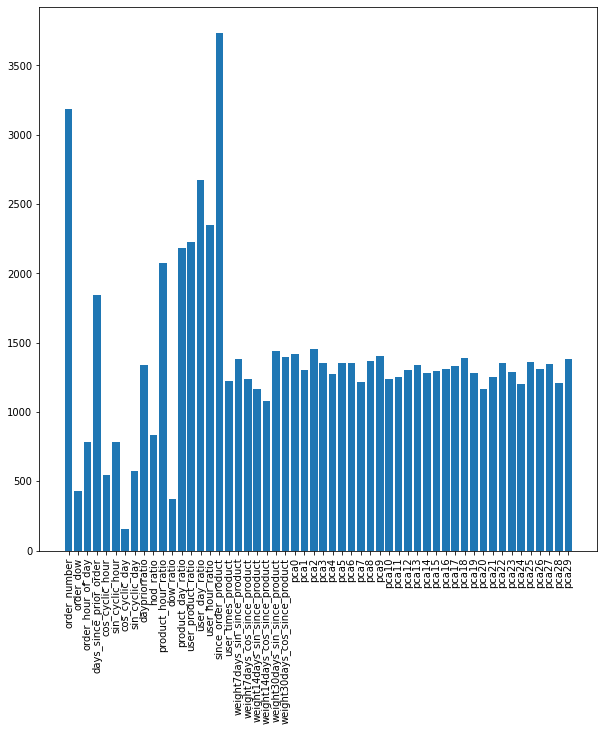

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(X_train.columns,lgbm.feature_importances_)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
pickle.dump(lgbm,open('/upload/lgbmmodel.sav','wb'))

In [ ]:
X_train.columns

Index(['order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'cos_cyclic_hour', 'sin_cyclic_hour',
       'cos_cyclic_day', 'sin_cyclic_day', 'daypriorratio', 'hod_ratio',
       'product_hour_ratio', 'dow_ratio', 'product_day_ratio',
       'user_product_ratio', 'user_day_ratio', 'user_hour_ratio',
       'since_order_product', 'user_times_product', 'pca0', 'pca1', 'pca2',
       'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10',
       'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'pca16', 'pca17', 'pca18',
       'pca19', 'pca20', 'pca21', 'pca22', 'pca23', 'pca24', 'pca25', 'pca26',
       'pca27', 'pca28', 'pca29'],
      dtype='object')

In [ ]:
test = Test[X_train.columns]

In [ ]:
result = loaded_model.predict(test)